In [62]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF info/warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')


In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Total tumor images (YES): 155
Total no tumor images (NO): 98


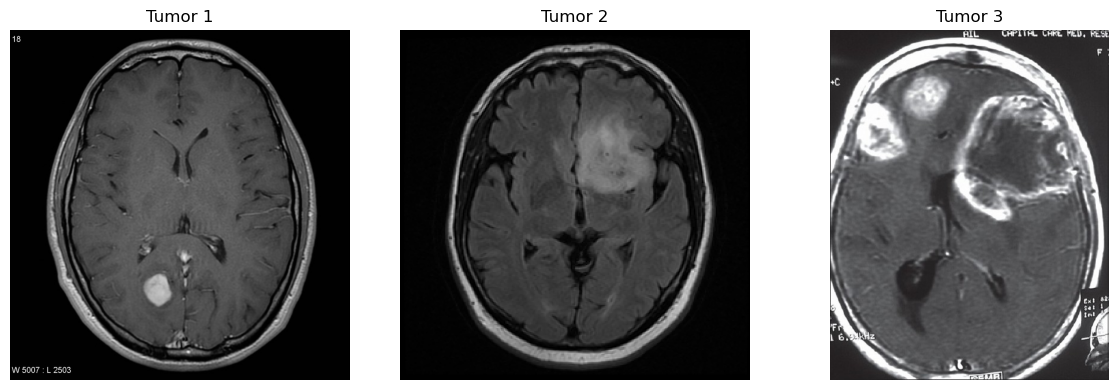

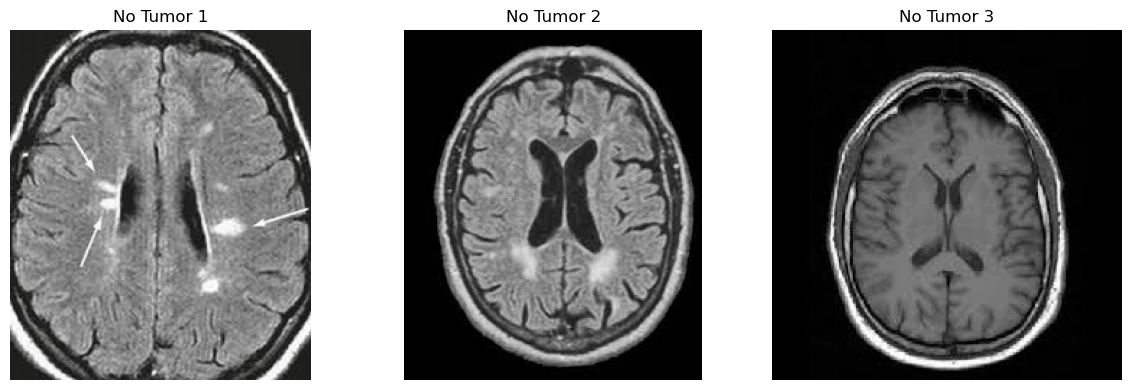

In [66]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

def get_images(folder_path):
    folder_path = folder_path.strip().rstrip('/\\')
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found -> {folder_path}")
        return []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG']
    image_files = []
    for ext in extensions:
        image_files.extend(glob(os.path.join(folder_path, ext)))
    return image_files

yes_images = get_images(os.path.join('Brain Tumour Detection', 'YES'))
no_images = get_images(os.path.join('Brain Tumour Detection', 'NO'))

print(f"Total tumor images (YES): {len(yes_images)}")
print(f"Total no tumor images (NO): {len(no_images)}")

def show_sample_images(image_paths, title, n=3):
    plt.figure(figsize=(12, 4))
    display_count = min(len(image_paths), n)
    if display_count == 0:
        print(f"No images found for {title}")
        return
    for i in range(display_count):
        try:
            with Image.open(image_paths[i]) as img:
                plt.subplot(1, display_count, i+1)
                plt.imshow(img)
                plt.title(f"{title} {i+1}")
                plt.axis('off')
        except Exception as e:
            print(f"Error loading image {image_paths[i]}: {e}")
    plt.tight_layout()
    plt.show()

show_sample_images(yes_images, "Tumor", 3)
show_sample_images(no_images, "No Tumor", 3)




In [68]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size and batch size
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Define paths
train_dir = 'Brain Tumour Detection'

# Data augmentation for training set (simple normalization + augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator (only normalization, no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)



Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [107]:
#Since brain tumor and no tumor classes might be imbalanced,
#using class weights helps the model pay more attention to the minority class during training, 
#improving overall prediction fairness.




from sklearn.utils import class_weight
import numpy as np

# Get class indices for all training samples
train_classes = train_generator.classes

# Compute class weights to balance classes during training
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_classes), 
                                                  y=train_classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights_dict
)


Class weights: {0: 1.2848101265822784, 1: 0.8185483870967742}
Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.7231 - loss: 0.5461 - val_accuracy: 0.6800 - val_loss: 0.5214
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.7308 - loss: 0.4951 - val_accuracy: 0.7800 - val_loss: 0.4860
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.7329 - loss: 0.5974 - val_accuracy: 0.7200 - val_loss: 0.4998
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.6870 - loss: 0.5503 - val_accuracy: 0.7400 - val_loss: 0.4641
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.8017 - loss: 0.5501 - val_accuracy: 0.7200 - val_loss: 0.5082
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.7098 - loss: 0.5443 - val_accuracy: 0.8000 - val_loss: 0.4467
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.7736 - loss: 0.5165 - val_accuracy: 0.7000 - val_loss: 0.7673
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accu

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

image_sizes = [(64, 64), (128, 128), (150, 150), (224, 224)]
batch_size = 32
epochs = 5

for size in image_sizes:
    print(f"\n--- Training with image size: {size} ---")

    # Update generators with new size
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True
    )
    validation_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # Build CNN model with input shape = new image size
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(*size, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )



--- Training with image size: (64, 64) ---
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5870 - loss: 0.6677 - val_accuracy: 0.6200 - val_loss: 0.7205
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5970 - loss: 0.6730 - val_accuracy: 0.6400 - val_loss: 0.5994
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6267 - loss: 0.6570 - val_accuracy: 0.6400 - val_loss: 0.5948
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6315 - loss: 0.6363 - val_accuracy: 0.6600 - val_loss: 0.5802
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.6494 - loss: 0.6177 - val_accuracy: 0.8000 - val_loss: 0.5284

--- Training with image size: (128, 128) ---
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.4587 - loss: 0.9604 - val_accuracy: 0.6400 - val_loss: 0.679

In [70]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1  # Optional: controls output verbosity during training
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.5141 - loss: 0.7588 - val_accuracy: 0.6400 - val_loss: 0.6386
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.5917 - loss: 0.6496 - val_accuracy: 0.6400 - val_loss: 0.6486
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - accuracy: 0.6615 - loss: 0.6037 - val_accuracy: 0.7200 - val_loss: 0.5866
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - accuracy: 0.6214 - loss: 0.6169 - val_accuracy: 0.7400 - val_loss: 0.5277
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.6886 - loss: 0.5842 - val_accuracy: 0.7600 - val_loss: 0.5418
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.7898 - loss: 0.5346 - val_accuracy: 0.7600 - val_loss: 0.5456
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 0.7030 - loss: 0.5720 - val_accuracy: 0.7600 - val_loss: 0.5450
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.7042 - loss: 0.5878 - val_accuracy: 0.7600 - val_loss:

In [ ]:
# Plot Training vs Validation Accuracy and Loss

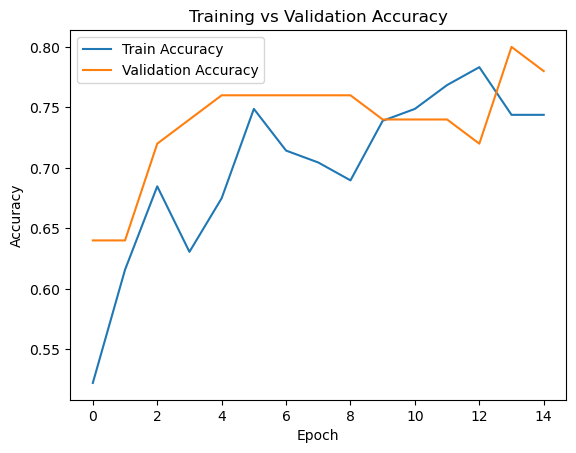

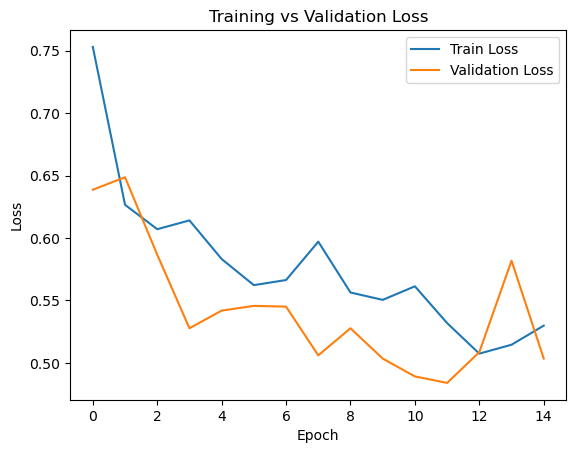

In [76]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves here
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.72      0.68      0.70        19
       Tumor       0.81      0.84      0.83        31

    accuracy                           0.78        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.78      0.78      0.78        50



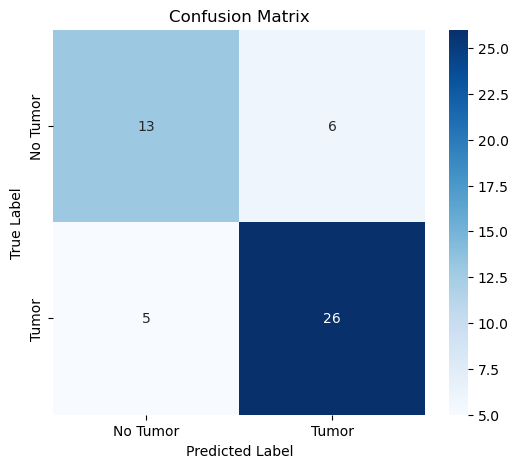

In [78]:
#The confusion matrix shows how many images the model correctly or incorrectly classified.
#Precision and recall tell us about false positives and false negatives, which are critical in medical diagnosis.




from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation data
validation_generator.reset()
preds = model.predict(validation_generator)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = validation_generator.classes

# Print classification report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=['No Tumor', 'Tumor']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


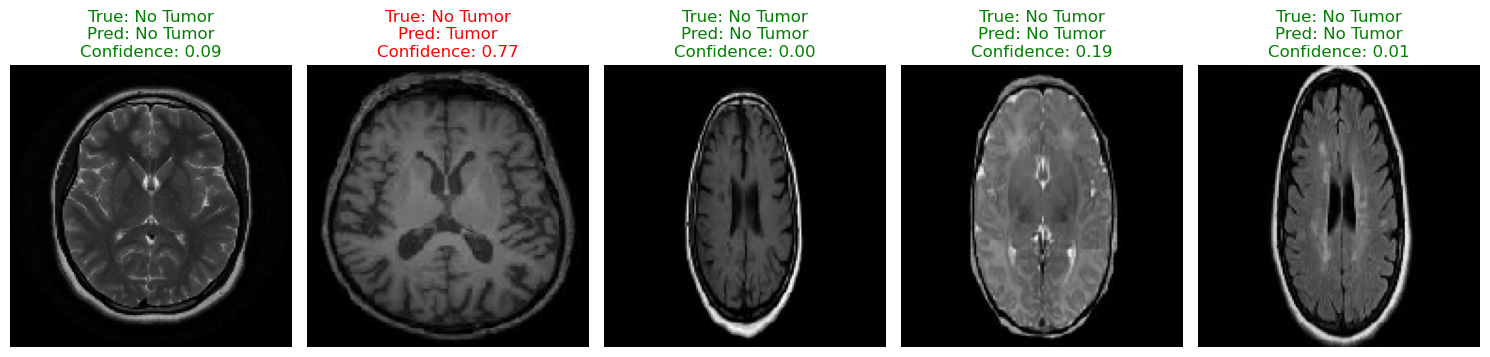

In [80]:
#Here are some test images with the predicted labels and the confidence scores. 
#The color indicates if the prediction was correct (green) or incorrect (red). 
#This helps us understand not just if the model is right, but how confident it is.



import numpy as np

def show_predictions(generator, model, class_names=['No Tumor', 'Tumor'], n=5):
    generator.reset()
    images, labels = next(generator)
    preds = model.predict(images)
    
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        true_label = class_names[int(labels[i])]
        pred_prob = preds[i][0]
        pred_label = class_names[int(pred_prob > 0.5)]
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConfidence: {pred_prob:.2f}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(validation_generator, model)


In [100]:
from sklearn.metrics import classification_report

val_true = validation_generator.classes
val_preds_prob = model.predict(validation_generator)
val_preds = (val_preds_prob > 0.5).astype(int)

print(classification_report(val_true, val_preds, target_names=validation_generator.class_indices.keys()))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
              precision    recall  f1-score   support

          NO       0.72      0.68      0.70        19
         YES       0.81      0.84      0.83        31

    accuracy                           0.78        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.78      0.78      0.78        50



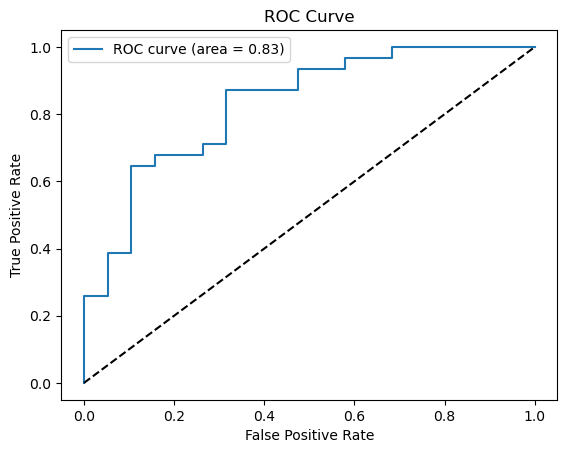

In [102]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(val_true, val_preds_prob)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
